# Pokemon

We want to construct a binary classifier on the feature `"type1"`, which can obtain values in `["water", "normal"]`

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data processing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    StratifiedShuffleSplit,
    RandomizedSearchCV,
    LeaveOneOut,
)

# Testing
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Utils
from sklearn.utils.multiclass import type_of_target
import pprint

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Random State

We set a random state constant to be used throughout the notebook for better reproducibility.

In [2]:
RANDOM_STATE = 529

# Data Pre-Processing Stage

We want to remove from our dataset all informations that should not be available to us, those are: `"type2"`, `"abilities"`, and every `"against_" + type` where `type` isn't `"electric"`. We can achieve this by dropping all columns matching the regular expression `"type2|classification|abilities|against_(?!electric)"` (in fact, there is a typo in the database, and "classification" is written as "classfication"). It should also be noted that the columns `["pokedex_number", "name", "japanese_name"]` columns are irrelevant for our classification problem, so  we'll also drop it. One may think that `"generation"` should also be dropped but it is known that different generations have distinct typing distributions so we'll stick to it.

In a second thought, the `"name"` column may be an interesting feature to exploit due to the fact that pokemons tend to maintain a suffix or prefix throughout the whole line of evolution. This however would require an encoder that preserves string morphology in order to maintain the similarities between the pokemon names. For the time being I do not know of a technique which can deal with this.

In [3]:
df = pd.read_csv("datasets/pokemon/pokemon.csv")
unknown = "type2|classfication|abilities|against_(?!electric)"
irrelevant = "pokedex_number|name|japanese_name"
df = df.drop(df.filter(regex=f"{unknown}|{irrelevant}", axis=1), axis=1)

Lets take a look at what we have in our hands by looking at the first few rows and the column names that remain in our dataframe.

In [4]:
df.head()

,against_electric,attack,base_egg_steps,base_happiness,base_total,capture_rate,defense,experience_growth,height_m,hp,percentage_male,sp_attack,sp_defense,speed,type1,weight_kg,generation,is_legendary
0,0.5,49,5120,70,318,45,49,1059860,0.7,45,88.1,65,65,45,grass,6.9,1,0
1,0.5,62,5120,70,405,45,63,1059860,1.0,60,88.1,80,80,60,grass,13.0,1,0
2,0.5,100,5120,70,625,45,123,1059860,2.0,80,88.1,122,120,80,grass,100.0,1,0
3,1.0,52,5120,70,309,45,43,1059860,0.6,39,88.1,60,50,65,fire,8.5,1,0
4,1.0,64,5120,70,405,45,58,1059860,1.1,58,88.1,80,65,80,fire,19.0,1,0


## The Minior Case

Upon inspection, the pokemon named Minior (row 773) has a catch rate (column 5) that is described as `"30 (Meteorite)255 (Core)"` so I decided to use the core catch rate 255 in order to be execute our substitution strategy for missing values correctly.

In [5]:
print(df.iloc[773, 5])
df.iloc[773, 5] = 255

30 (Meteorite)255 (Core)


## Choice of Features and Target Label

Below we choose the features that models should consider when predicting the target labelling function.

In [6]:
FEATURES = [
    #"base_total",
    #"speed",
    #"capture_rate",
    #"experience_growth",
    #"base_egg_steps",
    #"height_m",
    #"weight_kg",
    #"hp",
    #"sp_attack",
    #"attack",
    #"defense",
    #"sp_defense",
    "against_electric",
    #"base_happiness",
    #"percentage_male",
    #"is_legendary",
    #"generation",
]
LABEL = "type1"

## Filtering Pokemon Types

We'll only consider pokemons for which `"type1"` is in `["water", "normal"]`, so we create a function that removes every pokemon (row) that doesn't have an allowed type.

In [7]:
def filter_rows_by_value(df, col, values):
    return df[~df[col].isin(values)]

In [8]:
ALL_TYPE1 = set(df["type1"].unique())
ALLOWED_TYPE1 = {"water", "normal"}

df = filter_rows_by_value(df, LABEL, ALL_TYPE1 - ALLOWED_TYPE1).reset_index()

In [9]:
df.head()

,index,against_electric,attack,base_egg_steps,base_happiness,base_total,capture_rate,defense,experience_growth,height_m,hp,percentage_male,sp_attack,sp_defense,speed,type1,weight_kg,generation,is_legendary
0,6,2.0,48,5120,70,314,45,65,1059860,0.5,44,88.1,50,64,43,water,9.0,1,0
1,7,2.0,63,5120,70,405,45,80,1059860,1.0,59,88.1,65,80,58,water,22.5,1,0
2,8,2.0,103,5120,70,630,45,120,1059860,1.6,79,88.1,135,115,78,water,85.5,1,0
3,15,2.0,45,3840,70,251,255,40,1059860,0.3,40,50.0,35,35,56,normal,1.8,1,0
4,16,2.0,60,3840,70,349,120,55,1059860,1.1,63,50.0,50,50,71,normal,30.0,1,0


## Separating Data and Labels

In [10]:
X = df[FEATURES].to_numpy()
y = df[LABEL].to_numpy()

## Missing Data

Lets check which features contain missing values and replace those with the mean of the feature across all pokemons.

In [11]:
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
X = imp.fit_transform(X)

## Label Encoding

Lets encode each label (pokemon `"type1"` feature) with a uniquely representing integer. We'll also store the encoding mapping in a dictionary called `encoder_mapping`.

In [12]:
encoder = LabelEncoder().fit(y)
encoder_mapping = {type_: enc for enc, type_ in enumerate(encoder.classes_)}
y = encoder.transform(y)

In [13]:
print(encoder_mapping)

{'normal': 0, 'water': 1}


Later we'll use a stratification of the dataset grouping by the different types available in `"type1"`

## Feature Scaling

Notice that features have a huge scaling issue. For instance, we can have `"against_electric"` with a value of `0.5` while an `"experience_growth"` of `1059860`. To avoid feature domination problems, we'll scale every column accordingly. 

In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Cross Validation and Hyperparameter Tuning

## Separating Training, Validation, and Test Data

First we'll split our data (preserving label proportion, that is, the splitting is stratified) into a test set `(X_test, y_test)` and a training set `(X_search, y_search)` to be used in the hyperparameter tuning and cross-validation stage.

## Constants

In [15]:
# Percentage of the whole dataset to be used as test.
TEST_SIZE = 0.1

# Percentage of the search data to be used as validation.
VALIDATION_SIZE = 0.1

# Number of splits for the cross-validation.
N_SPLITS = 10

# Number of iterations of the randomized searcher with cross-validation.
N_ITER = 10 

# Verboseness of the search (the higher, we have more verboseness).
VERBOSE_LEVEL = 1

# Cross-validation method to be used in conjunction with the hyperparameter tuning.
CV_STRATEGY=StratifiedShuffleSplit 

## Search Set and Test Set Sampling

In [16]:
X_search, X_test, y_search, y_test = train_test_split(
    X, y, shuffle=True, stratify=y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

## Randomized Search with Cross Validation

In [17]:
def random_searcher(
    estimator,
    param_distributions,
    X_search,
    y_search,
    X_test,
    y_test,
    n_iter=N_ITER,
    cv=CV_STRATEGY,
    n_splits=N_SPLITS
):
    rs = RandomizedSearchCV(
        estimator=estimator(),
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv(n_splits=n_splits, test_size=VALIDATION_SIZE, random_state=RANDOM_STATE),
        verbose=VERBOSE_LEVEL,
    ).fit(X_search, y_search, groups=y_search)
    
    predictions = rs.best_estimator_.predict(X_test)
    
    # This will automatically plot the confusion matrices.
    cmap = plt.cm.BuPu
    labels = list(encoder_mapping)
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test,
        predictions,
        cmap=cmap,
        display_labels=labels,
    )
    ncm = ConfusionMatrixDisplay.from_predictions(
        y_test,
        predictions,
        cmap=cmap,
        normalize="true",
        display_labels=labels,
    )
    
    return {
        "model": estimator.__name__,
        "dataset": {
            "dataset size": len(X),
            "number of features": X_search.shape[1] if len(X_search.shape) == 2 else 1,
            "target type": type_of_target(y),
        },
        "hyperparameter tuning and cross-validation": {
            "parameter seach strategy": "RandomizedSearchCV",
            "number of search iterations": n_iter,
            "search size": len(X_search),
            "random state": RANDOM_STATE,
            "cross validation strategy": cv.__name__,
            "number of cross validation splits": n_iter,
            "best estimator parameters": rs.best_estimator_.get_params(),
            "mean accuracy in CV": rs.best_score_,
        },
        "test": {
            "test size": len(X_test),
            "accuracy": accuracy_score(y_test, rs.best_estimator_.predict(X_test)),
            "confusion matrix": cm.confusion_matrix,
            "normalized confusion matrix": ncm.confusion_matrix,
        },
    }

In [18]:
def print_searcher_info(searcher_results):
    np.set_printoptions(precision=2)
    model_name = searcher_results["model"]
    print(f"{f' {model_name} ':=^80}")
    
    for key in list(searcher_results)[1:]:
        print(f"\n\n{f' {key} ':-^80}")
        pprint.pprint(searcher_results[key], sort_dicts=False)

# Model Evaluation

## Logistic Regression

Fitting 10 folds for each of 10 candidates, totalling 100 fits


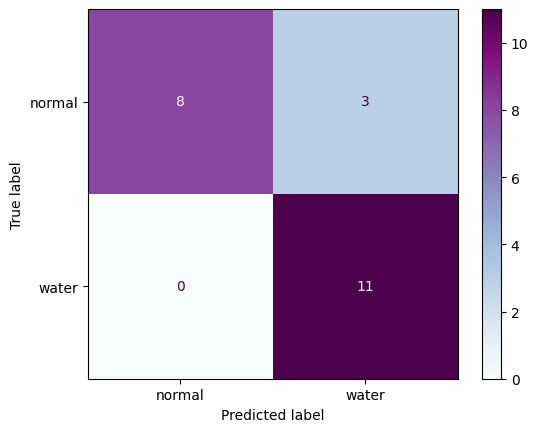

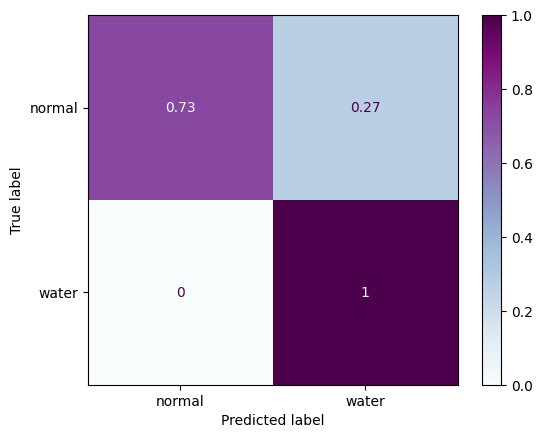

In [19]:
param_distributions = {
    "C": np.absolute(np.random.normal(loc=1.0, scale=1.0, size=100)),
}
logistic_regression = random_searcher(
    LogisticRegression,
    param_distributions,
    X_search,
    y_search,
    X_test,
    y_test
)

In [20]:
print_searcher_info(logistic_regression)

============================== LogisticRegression ==============================


----------------------------------- dataset ------------------------------------
{'dataset size': 219, 'number of features': 1, 'target type': 'binary'}


------------------ hyperparameter tuning and cross-validation ------------------
{'parameter seach strategy': 'RandomizedSearchCV',
 'number of search iterations': 10,
 'search size': 197,
 'random state': 529,
 'cross validation strategy': 'StratifiedShuffleSplit',
 'number of cross validation splits': 10,
 'best estimator parameters': {'C': 1.6615843739754534,
                               'class_weight': None,
                               'dual': False,
                               'fit_intercept': True,
                               'intercept_scaling': 1,
                               'l1_ratio': None,
                               'max_iter': 100,
                               'multi_class': 'auto',
                               'n_jobs

## Support Vector Machines

Fitting 10 folds for each of 10 candidates, totalling 100 fits


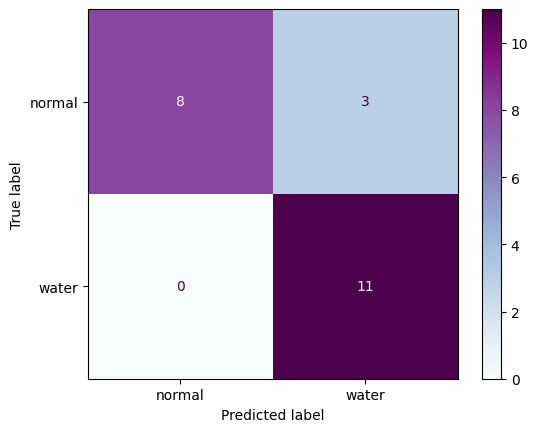

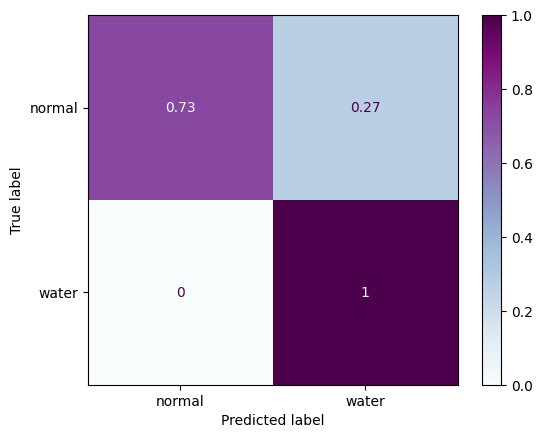

In [21]:
param_distributions = {
    "C": np.absolute(np.random.normal(loc=1.0, scale=1.0, size=10)),
    "gamma": ["scale", "auto"] + np.absolute(np.random.normal(size=5)).tolist(),
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": np.arange(1, 6),
    "random_state": [RANDOM_STATE],
}
support_vector_machine = random_searcher(
    SVC,
    param_distributions,
    X_search,
    y_search,
    X_test,
    y_test
)

In [22]:
print_searcher_info(support_vector_machine)

===================================== SVC ======================================


----------------------------------- dataset ------------------------------------
{'dataset size': 219, 'number of features': 1, 'target type': 'binary'}


------------------ hyperparameter tuning and cross-validation ------------------
{'parameter seach strategy': 'RandomizedSearchCV',
 'number of search iterations': 10,
 'search size': 197,
 'random state': 529,
 'cross validation strategy': 'StratifiedShuffleSplit',
 'number of cross validation splits': 10,
 'best estimator parameters': {'C': 1.4466550355481909,
                               'break_ties': False,
                               'cache_size': 200,
                               'class_weight': None,
                               'coef0': 0.0,
                               'decision_function_shape': 'ovr',
                               'degree': 3,
                               'gamma': 0.9210430653521947,
                            

## Decision Tree

Fitting 10 folds for each of 10 candidates, totalling 100 fits


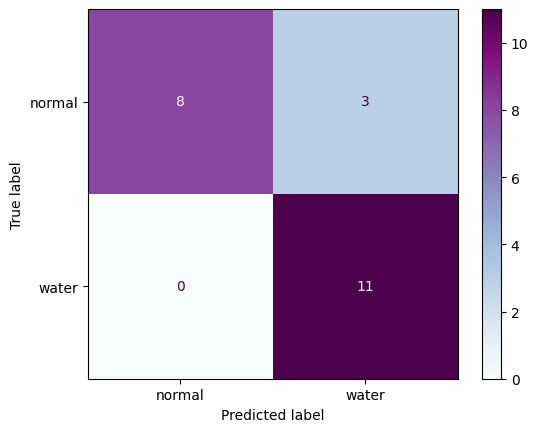

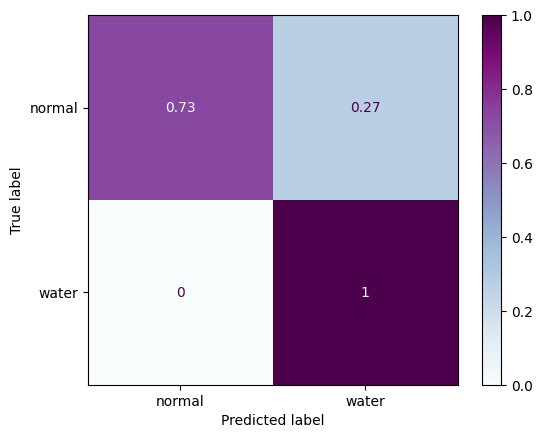

In [23]:
param_distributions = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": np.arange(1, 20),
    "max_leaf_nodes": np.arange(20, 70),
    "min_samples_leaf": np.arange(1, 4),
    "random_state": [RANDOM_STATE],
}
decision_tree = random_searcher(
    DecisionTreeClassifier,
    param_distributions,
    X_search,
    y_search,
    X_test,
    y_test
)

In [24]:
print_searcher_info(decision_tree)

============================ DecisionTreeClassifier ============================


----------------------------------- dataset ------------------------------------
{'dataset size': 219, 'number of features': 1, 'target type': 'binary'}


------------------ hyperparameter tuning and cross-validation ------------------
{'parameter seach strategy': 'RandomizedSearchCV',
 'number of search iterations': 10,
 'search size': 197,
 'random state': 529,
 'cross validation strategy': 'StratifiedShuffleSplit',
 'number of cross validation splits': 10,
 'best estimator parameters': {'ccp_alpha': 0.0,
                               'class_weight': None,
                               'criterion': 'entropy',
                               'max_depth': 13,
                               'max_features': None,
                               'max_leaf_nodes': 36,
                               'min_impurity_decrease': 0.0,
                               'min_samples_leaf': 1,
                           

## Random Forest

Fitting 10 folds for each of 5 candidates, totalling 50 fits


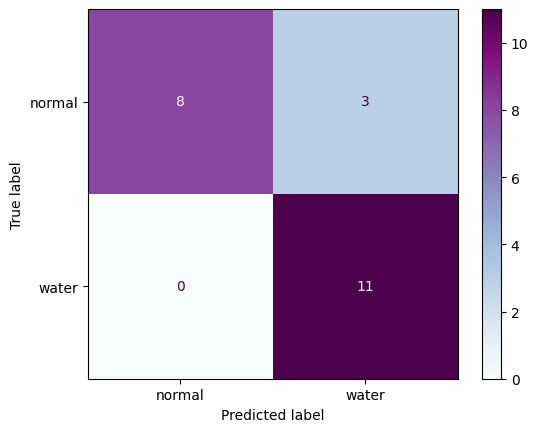

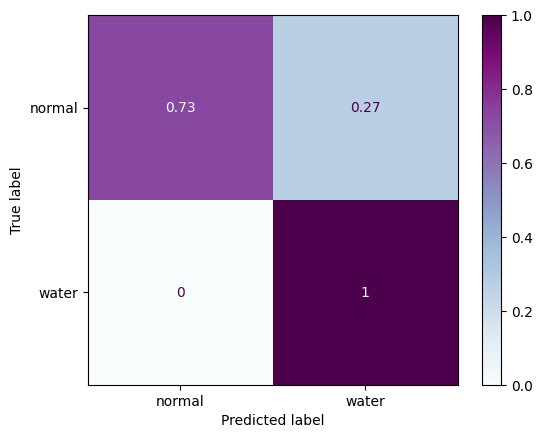

In [25]:
param_distributions = {
    "n_estimators": np.arange(100, 1500, 100),
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": np.arange(1, 20),
    "min_samples_leaf": np.arange(1, 4),
    "random_state": [RANDOM_STATE],
    "n_jobs": [-1], # Use all cores
}
random_forest = random_searcher(
    RandomForestClassifier,
    param_distributions,
    X_search,
    y_search,
    X_test,
    y_test,
    n_iter=5
)

In [26]:
print_searcher_info(random_forest)

============================ RandomForestClassifier ============================


----------------------------------- dataset ------------------------------------
{'dataset size': 219, 'number of features': 1, 'target type': 'binary'}


------------------ hyperparameter tuning and cross-validation ------------------
{'parameter seach strategy': 'RandomizedSearchCV',
 'number of search iterations': 5,
 'search size': 197,
 'random state': 529,
 'cross validation strategy': 'StratifiedShuffleSplit',
 'number of cross validation splits': 5,
 'best estimator parameters': {'bootstrap': True,
                               'ccp_alpha': 0.0,
                               'class_weight': None,
                               'criterion': 'gini',
                               'max_depth': 18,
                               'max_features': 'sqrt',
                               'max_leaf_nodes': None,
                               'max_samples': None,
                               'min_impur

# Conclusion

Lets summarize all of the accuracy scores:

In [27]:
models = [logistic_regression, support_vector_machine, decision_tree, random_forest]

for model in models:
    print(f"{model['model']} accuracy: {model['test']['accuracy']:.3f}")

LogisticRegression accuracy: 0.864
SVC accuracy: 0.864
DecisionTreeClassifier accuracy: 0.864
RandomForestClassifier accuracy: 0.864


The results above are favorable for the tree based models (decision tree and random forest), with scores ranging from 86% to 90%. However, logistic regression and support vector machine models do not sit at bad position too, with scores around 86%.